# Lens modelling of a Euclid-Q1 lens

Example notebook to optimize parameters of a lens model fitted to a Euclid-discovered lens from the Q1 data release.

The strong lens system is just one of many found in the [Euclid Quick Data Release (Q1): The Strong Lensing Discovery Engine](https://zenodo.org/records/15025832) data release from [Walmsley et al. 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250315324E/abstract).

__Author__: Aymeric Galan

__Created__: 06/05/25

__Updated__: 06/05/25

In [ ]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from pprint import pprint
from astropy.io import fits
from regions import Regions

# JAX
import jax
jax.config.update("jax_enable_x64", True)  # comment for single precision
import jax.numpy as jnp

# probabilistic model
import numpyro
import numpyro.distributions as dist

# Herculens
import herculens as hcl
from herculens.Util import param_util, plot_util

## Load and prepare the data

We consider only the VIS data in this example, but the FITS file also contains also NIR Y, J and H bands.

In [2]:
data_dir = "data/Euclid_Q1_strong_lensing_discovery_engine"
data_filename = "102020532_NEG589257492489565961.fits"

# Read the FITS file
# imaging data
data_vis, data_vis_hdr = fits.getdata(os.path.join(data_dir, data_filename), extname="VIS_FLUX", header=True)
data_vis = data_vis.astype(np.float64)

# PSF
psf_kernel_vis = fits.getdata(os.path.join(data_dir, data_filename), extname="VIS_PSF", header=False)
psf_kernel_vis = psf_kernel_vis.astype(np.float64)

# noise map
noise_map_vis = fits.getdata(os.path.join(data_dir, data_filename), extname="VIS_RMS", header=False)
noise_map_vis = noise_map_vis.astype(np.float64)

Get the pixel size from the distortion matrix

In [3]:
CD1_1 = data_vis_hdr['CD1_1'] 
CD1_2 = data_vis_hdr['CD1_2']
CD2_1 = data_vis_hdr['CD2_1']
CD2_2 = data_vis_hdr['CD2_2']
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]]) * 3600.  # convert degrees to arcsec
pix_scl = np.sqrt(np.abs(np.linalg.det(pix2coord_transform_undistorted)))
print("Pixel scale: ", pix_scl)

Pixel scale:  0.10000000000000801


Crop the data to focus on just the lens

In [4]:
def extract_central_square(array, square_size):
    """
    Extract a central square from a 2D array.
    """
    center = np.array(array.shape) // 2
    half_size = square_size // 2
    return array[center[0] - half_size:center[0] + half_size, center[1] - half_size:center[1] + half_size]

# Extract a central square of size 100x100 pixels
cutout_size = 60
data = extract_central_square(data_vis, cutout_size)
noise_map = extract_central_square(noise_map_vis, cutout_size)

Visualize the prepared data

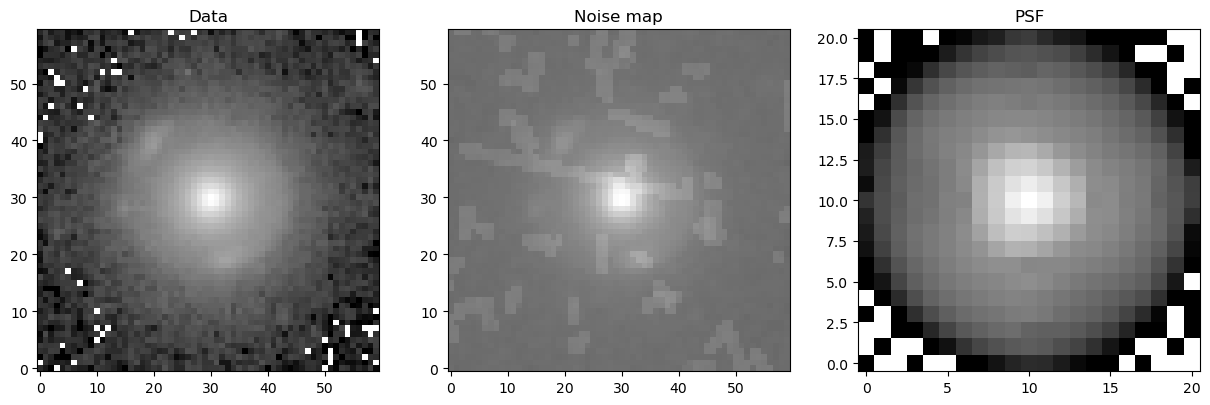

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data, cmap='gray', origin='lower', norm=LogNorm(vmin=1e-3))
axes[0].set_title("Data")
axes[1].imshow(noise_map, cmap='gray', origin='lower', norm=LogNorm(vmin=1e-3))
axes[1].set_title("Noise map")
axes[2].imshow(psf_kernel_vis, cmap='gray', origin='lower', norm=LogNorm(vmin=1e-6))
axes[2].set_title("PSF")
plt.show()

The following cell is just to save the smaller cutouts and prepare masks

In [6]:
# save the data cutout to a FITS file
cutout_path = os.path.join(data_dir, "cutout.fits")
fits.writeto(cutout_path, data, overwrite=True)

Load the masks that have been created using DS9

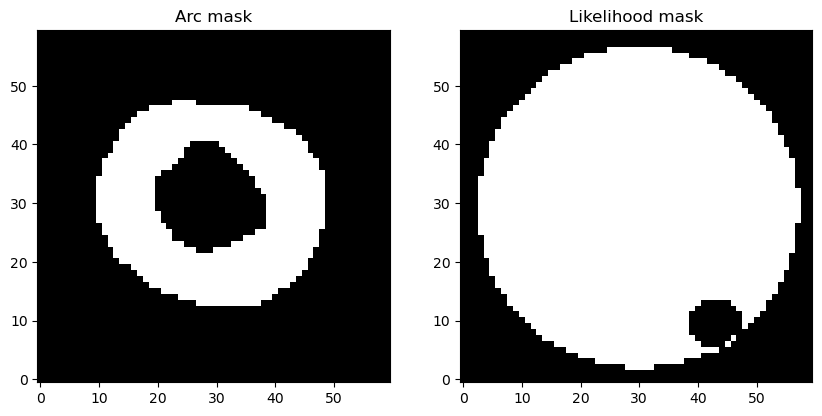

In [7]:
arcmask_path = os.path.join(data_dir, "cutout_arcmask.reg")  # circular region to remove un-modelled structures close to corners
arcmask_regions = Regions.read(arcmask_path, format='ds9')
arc_mask = (arcmask_regions[1] ^ arcmask_regions[0]).to_mask().to_image(data.shape)

ll_mask_path = os.path.join(data_dir, "cutout_likelihood_mask.reg")  # circular region to remove un-modelled structures close to corners
ll_mask_regions = Regions.read(ll_mask_path, format='ds9')
likelihood_mask = (ll_mask_regions[1] ^ ll_mask_regions[0]).to_mask().to_image(data.shape)

# show the two masks
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(arc_mask, cmap='gray', origin='lower')
axes[0].set_title("Arc mask")
axes[1].imshow(likelihood_mask, cmap='gray', origin='lower')
axes[1].set_title("Likelihood mask")
plt.show()

## Prepare the forward modelling engine

### Coordinates grid

In [8]:
npix, npix_y = data.shape  # number of pixel on a side
assert npix == npix_y, "The image is not square"
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (60, 60) pixels
pixel size : 0.10000000000000801 arcsec
x range    : (np.float64(-2.9500000000002364), np.float64(2.9500000000002364)) arcsec
y range    : (np.float64(-2.9500000000002364), np.float64(2.9500000000002364)) arcsec


### Point spread function (PSF) model

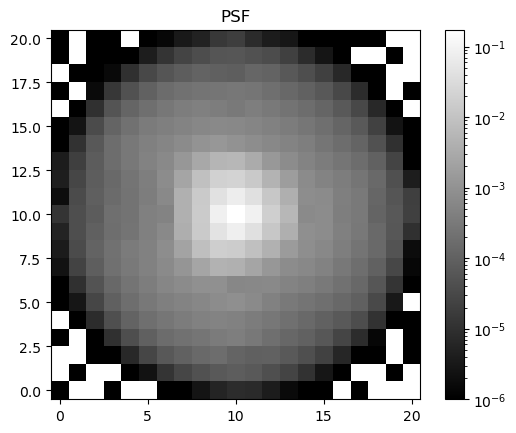

In [9]:
psf_model = hcl.PSF(psf_type='PIXEL', kernel_point_source=psf_kernel_vis, kernel_supersampling_factor=1)

plt.title("PSF")
plt.imshow(psf_model.kernel_point_source, cmap='gray', origin='lower', norm=LogNorm(vmin=1e-6))
plt.colorbar()
plt.show()

### Noise model

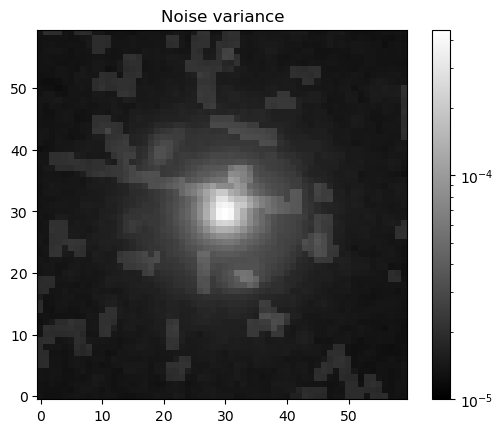

In [10]:
noise_model = hcl.Noise(npix, npix, exposure_time=None, background_rms=None, noise_map=noise_map)

plt.title("Noise variance")
plt.imshow(noise_model.C_D, cmap='gray', origin='lower', norm=LogNorm(vmin=1e-5))
plt.colorbar()
plt.show()

### Model components

#### Mass model

This is an elliptical power-law profile embedded in a shear field.

In [11]:
# Lens mass
mass_model = hcl.MassModel([
    hcl.EPL(), 
    hcl.Shear(),
])

#### Lens light model

This is the superimposition of two Sérsic profiles.

In [12]:
# Lens light
lens_light_model = hcl.LightModel(
    [
        hcl.SersicElliptic(),
        hcl.SersicElliptic(),
    ],
)

#### Source light model

This is a correlated field model defined a regular grid of pixels.

In [13]:
num_source_pixels = 100
source_model = hcl.LightModel(
    hcl.PixelatedLight(
        interpolation_type='fast_bilinear',   # requires jaxinterp2d to be installed
        adaptive_grid=True,  # source grid extent will adapt using the arc mask
        allow_extrapolation=False,  # essentially says it should be zero outside the source grid
    ),
    kwargs_pixelated=dict(num_pixels=num_source_pixels),
)

mean_source_intensity = 1e-2  # set it by hand based on the brightness of initial guess
source_field = hcl.CorrelatedField(
    "source_pixels", 
    source_model, 
    offset_mean=np.log(mean_source_intensity),  # take the log because exponentiate=True
    prior_offset_std=(0.5, 1e-3),
    prior_loglogavgslope=(-6., 0.5),  # this drives how smooth the field is: the smaller the slope mean (first value), the smoother the resulting field
    prior_fluctuations=(1., 0.5),
    prior_flexibility=None,
    prior_asperity=None,
    cropped_border_size=20,
    exponentiate=True,
)

Exponential Cropped correlated field prior for 'source_pixels'
New '2d' CorrelatedField model successfully created (final shape is (100, 100)).


### Put the components together into a forward model

In [14]:
kwargs_numerics = {'supersampling_factor': 1}  # more accurate results are obtained with a higher supersampling factor
lens_image = hcl.LensImage(
    pixel_grid, 
    psf_model,
    noise_class=noise_model, 
    lens_mass_model_class=mass_model,
    lens_light_model_class=lens_light_model,
    source_model_class=source_model, 
    source_arc_mask=arc_mask.astype(bool),
    kwargs_numerics=kwargs_numerics,
)

### Set up the plotting engine

In [15]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=3e-3, flux_vmax=1e0, res_vmax=5)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

## Define the probabilistic model

In [16]:
class ProbModel(hcl.NumpyroModel):
    
    def model(self):
        # Parameters of the source
        prior_source = [
            {
                'pixels': source_field.numpyro_sample_pixels(),
            }
        ]

        # Parameters of the lens light and mass
        # center of the lens
        cx = numpyro.sample('light_cx', dist.Uniform(-pix_scl, +pix_scl))
        cy = numpyro.sample('light_cy', dist.Uniform(-pix_scl, +pix_scl))
        # ellipticity of the lens light
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(0., 0.05, low=-0.1, high=0.1))
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(0., 0.05, low=-0.1, high=0.1))
        prior_lens = [
            # power-law
            {
                'theta_E': numpyro.sample('lens_theta_E', dist.Uniform(1.2, 1.5)),
                'gamma': numpyro.sample('lens_gamma', dist.TruncatedNormal(2., 0.05, low=1.8, high=2.2)),
                'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(e1, 0.02, low=-0.1, high=0.1)),
                'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(e2, 0.02, low=-0.1, high=0.1)),
                'center_x': cx,
                'center_y': cy,
            },
            # external shear, with fixed origin
            {
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(0., 0.05, low=-0.1, high=0.1)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(0., 0.05, low=-0.1, high=0.1)), 
                'ra_0': 0., 
                'dec_0': 0.,
            }
        ]
        prior_lens_light = [
            {
                'amp': numpyro.sample('light_amp', dist.LogNormal(2., 0.5)),
                'R_sersic': numpyro.sample('light_R_sersic', dist.Uniform(0.05, 0.8)),
                'n_sersic': 1.,  # = exponential profile
                'e1': e1,
                'e2': e2,
                'center_x': cx,
                'center_y': cy,
            },
            {
                'amp': numpyro.sample('light_amp_2', dist.LogNormal(2., 0.5)),
                'R_sersic': numpyro.sample('light_R_sersic_2', dist.Uniform(0.8, 1.5)),
                'n_sersic': 4.,  # = de Vaucouleur profile
                'e1': e1,
                'e2': e2,
                'center_x': cx,
                'center_y': cy,
            },
        ]
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_mean = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_std = jnp.sqrt(lens_image.C_D_model(model_mean))

        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample(
            'obs',  # important that it has this key
            dist.Independent(dist.Normal(model_mean, model_std).mask(likelihood_mask.astype(bool)), 2),   # applying the likelihood mask here
            obs=data, # = conditioned on the observed data
        )
    
    def params2kwargs(self, params):
        # Pack the parameters for Herculens
        # Lens mass
        #e1_conv, e2_conv = param_util.phi_q2_ellipticity(params['lens_phi'], params['lens_q'])
        kwargs_lens = [
            {
                'theta_E': params['lens_theta_E'],
                'gamma': params['lens_gamma'],
                'e1': params['lens_e1'], 
                'e2': params['lens_e2'],
                'center_x': params['light_cx'], 
                'center_y': params['light_cy'], 
            },
            {
                'gamma1': params['lens_gamma1'], 
                'gamma2': params['lens_gamma2'], 
            }
        ]

        # Lens light
        kwargs_lens_light = [
            {
                'amp': params['light_amp'],
                'R_sersic': params['light_R_sersic'],
                'n_sersic': 1.,
                'e1': params['light_e1'], 
                'e2': params['light_e2'],
                'center_x': params['light_cx'],
                'center_y': params['light_cy'],
            },
            {
                'amp': params['light_amp_2'],
                'R_sersic': params['light_R_sersic_2'],
                'n_sersic': 4.,
                'e1': params['light_e1'], 
                'e2': params['light_e2'],
                'center_x': params['light_cx'],
                'center_y': params['light_cy'],
            },
        ]

        # Source light
        kwargs_source = [{'pixels': source_field.model(params)}]

        return dict(kwargs_lens=kwargs_lens, 
                    kwargs_lens_light=kwargs_lens_light, 
                    kwargs_source=kwargs_source)

In [17]:
prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

Number of parameters: 19617


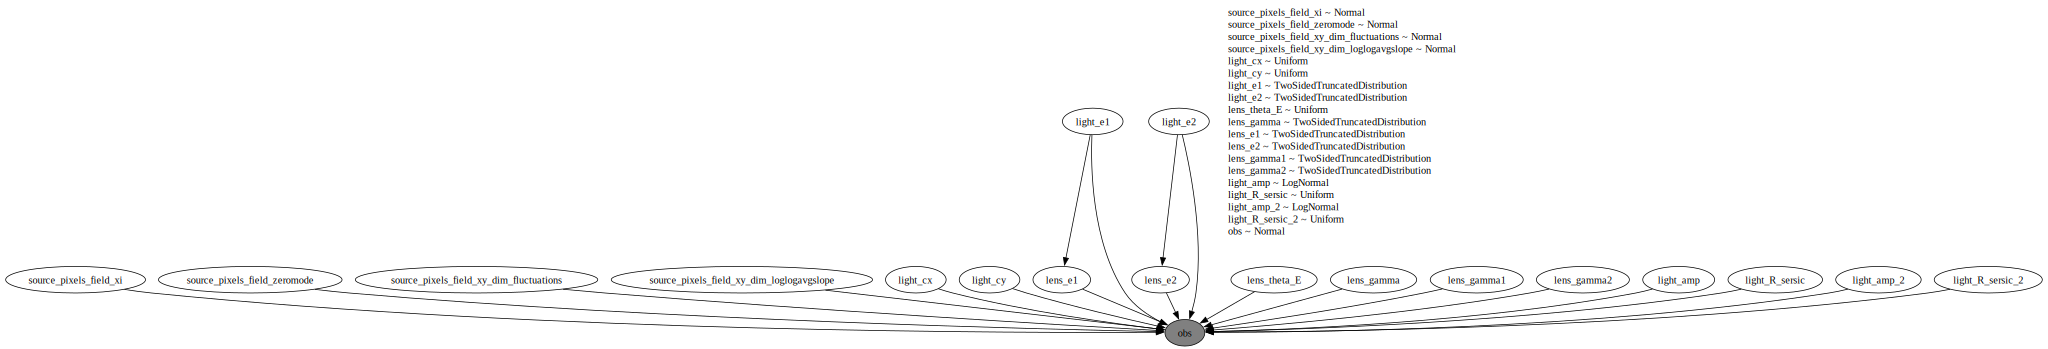

In [18]:
# visualize the probabilistic graph thanks to NumPyro utility
numpyro.render_model(
    prob_model.model,
    render_distributions=True, 
    render_params=True,
)

### Visualize the (random) initial guess

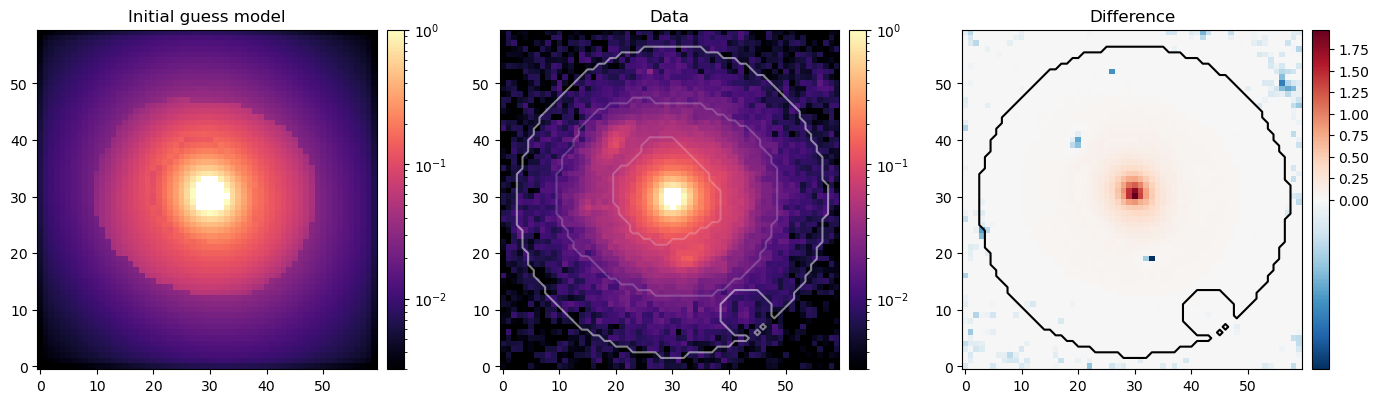

In [19]:
seed = 86  # change the seed to 0 to get different initial parameters
prng_key = jax.random.PRNGKey(seed)
init_params = prob_model.get_sample(prng_key)

# constrained space
init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space
kwargs_init = prob_model.params2kwargs(init_params)  # constrained space
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax.contour(likelihood_mask, levels=[0.5], colors='white', alpha=0.5)
ax.contour(arc_mask, levels=[0.5], colors='white', alpha=0.2)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
ax.contour(likelihood_mask, levels=[0.5], colors='black')
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

## Optimise the model parameters

In [20]:
loss = hcl.Loss(prob_model)
print("Initial loss =", loss(init_params_unconst))
#print("Initial gradient =", loss.gradient(init_params_unconst))

Initial loss = 184814.98198113116


In [21]:
optimizer = hcl.OptaxOptimizer(loss, loss_norm_optim=data.size)  # loss_norm_optim is to reduce loss magnitude

best_fit, logL_best_fit, extra_fields, runtime = optimizer.run(
    init_params_unconst, 
    max_iterations=4_000,   # adapt this based on the plot in next cell
    init_learning_rate=1e-3,  # adapt this based on the plot in next cell
)
print("Runtime:", runtime)

optax.adabelief: 100%|██████████| 4000/4000 [00:18<00:00, 214.14it/s]


Runtime: 18.698410034179688


Final loss = 8879.76812026161


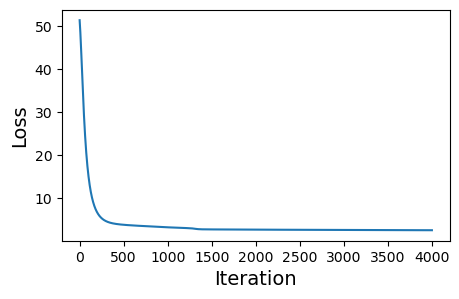

In [22]:
print("Final loss =", loss(best_fit))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
plt.show()

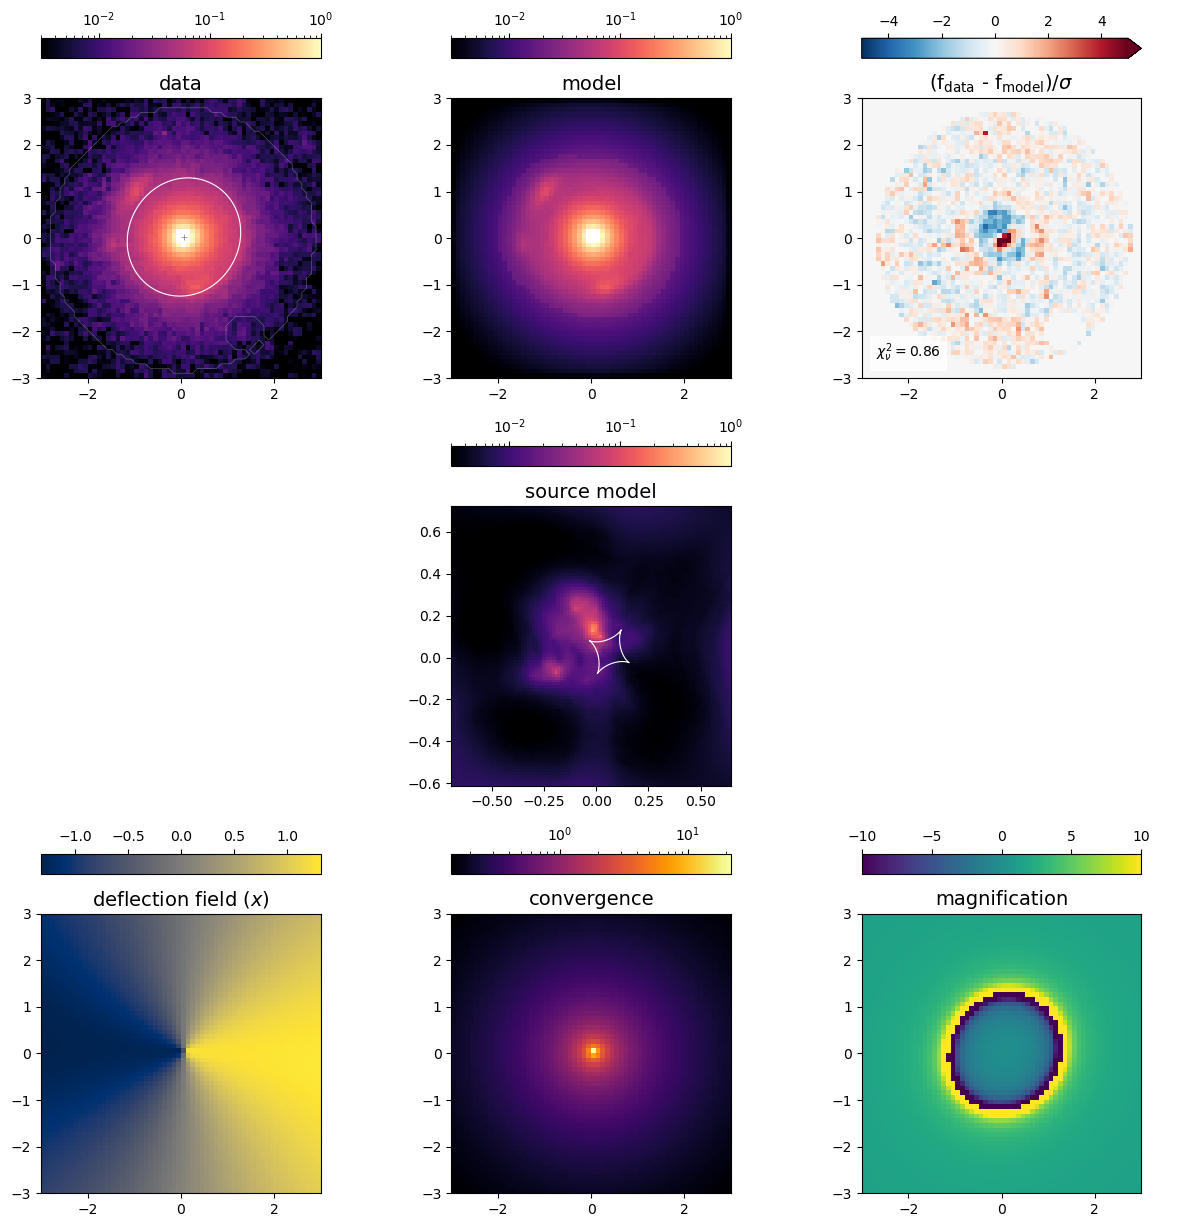

In [23]:
# the best-fit values are in unconstrained space so we transform them here
best_fit_constrained = prob_model.constrain(best_fit)
kwargs_best_fit = prob_model.params2kwargs(best_fit_constrained)

fig = plotter.model_summary(lens_image, 
                            kwargs_best_fit, 
                            likelihood_mask=likelihood_mask,
                            show_lens_others=True,
                            show_source=True,
                            show_lens_lines=True)
plt.show()


In [24]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_best_fit)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': Array(0.06395458, dtype=float64),
                  'center_y': Array(0.02443839, dtype=float64),
                  'e1': Array(0.01021116, dtype=float64),
                  'e2': Array(-0.00140637, dtype=float64),
                  'gamma': Array(2.01104496, dtype=float64),
                  'theta_E': Array(1.23614398, dtype=float64)},
                 {'gamma1': Array(0.03129027, dtype=float64),
                  'gamma2': Array(-0.03970377, dtype=float64)}],
 'kwargs_lens_light': [{'R_sersic': Array(0.19629117, dtype=float64),
                        'amp': Array(11.21137525, dtype=float64),
                        'center_x': Array(0.06395458, dtype=float64),
                        'center_y': Array(0.02443839, dtype=float64),
                        'e1': Array(0.00191655, dtype=float64),
                        'e2': Array(-0.01200683, dtype=float64),
                        'n_sersic': 1.0},
                       {'R_sersic': Arr